# LG 입자 형태분석 모델개발 해커톤 base line

&nbsp;

## 기본설정

&nbsp;

### colab 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


&nbsp;

### pytorch 버전확인

In [ ]:
import torch
import os
torch.__version__

'1.12.0+cu113'

&nbsp;

### mmdetection 폴더 생성 및 이동

In [ ]:
import os

os.chdir('/content/')
os.mkdir('lg_test')
os.chdir('lg_test')

- 경로 확인

In [ ]:
os.getcwd()

'/content/lg_test'

&nbsp;

### mmdetection 설치
- colab 기준으로 설정한 설치 과정 만약 임의의 pytorch 버전 사용 시 밑의 과정은 달라질 수 있음

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirements/build.txt
!pip install -v -e .

- mmdet 버전확인

In [ ]:
import mmdet
print(mmdet.__version__)

2.25.1


- 폴더 확인

In [ ]:
os.listdir()

['requirements',
 'tools',
 'CITATION.cff',
 '.gitignore',
 'setup.cfg',
 'MANIFEST.in',
 'setup.py',
 'demo',
 '.dev_scripts',
 'configs',
 'mmdet.egg-info',
 'requirements.txt',
 '.git',
 'docker',
 'resources',
 'README_zh-CN.md',
 '.readthedocs.yml',
 'docs',
 '.pre-commit-config.yaml',
 'tests',
 '.circleci',
 'README.md',
 'LICENSE',
 '.github',
 'model-index.yml',
 'pytest.ini',
 'mmdet',
 '.owners.yml']

&nbsp;

## 데이터 다운 및 데이터 확인

- 해당 경로 확인

In [ ]:
os.getcwd()

'/content/lg_test/mmdetection'

### 데이터 폴더 생성 및 이동

In [ ]:
%mkdir data

In [ ]:
%cd data

/content/lg_test/mmdetection/data


&nbsp;

### 데이터 다운 [lg 데이터](https://drive.google.com/file/d/1kepvD1uQqhRBhkNb08r3rmocA2U3-3NF/view)

In [ ]:
os.getcwd()

'/content/lg_test/mmdetection/data'

In [ ]:
!gdown --id 1kepvD1uQqhRBhkNb08r3rmocA2U3-3NF

- 압축풀기

In [ ]:
os.getcwd()

'/content/lg_test/mmdetection/data'

In [ ]:
!unzip -qq  "/content/lg_test/mmdetection/data/dataset.zip"

&nbsp;

### label_test.json 수정

In [ ]:
import json

with open("/content/lg_test/mmdetection/data/dataset/label_test.json") as f:
  data_train = json.load(f)

data_train['categories'] = [{'id': 1, 'name': 'Normal'}]

print(data_train.keys())

with open('/content/lg_test/mmdetection/data/dataset/test.json', 'w') as f:
    json.dump(data_train, f)

dict_keys(['images', 'categories'])


&nbsp;

## Mask R-CNN base-line

### config 사용

- mmdetection에서 제공하는 config 사용 시 원하는 변수로 설정해야 합니다.
- 빠르게 모델 inference를 수행할 때 좋습니다.
- json 출력 파일을 만들기 위해 mmdetection/tools/test.py 에서 필요한 부분에 변경을 수행했습니다.


&nbsp;

### mask r_cnn 사전 가중치 다운로드

In [ ]:
os.chdir('/content/lg_test/mmdetection/')
os.mkdir('checkpoint')
os.chdir('checkpoint')

from requests import get 

def download(url, file_name):
    with open(file_name, "wb") as file:   
        response = get(url)               
        file.write(response.content)


url = "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth"
download(url,"mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth")

os.chdir('/content/lg_test/mmdetection/')

&nbsp;

### config 지정

In [ ]:
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector
from mmdet.apis import set_random_seed

def set_config():
  # 사용할 모델 초기 py 설정
  config = './configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

  # config 불러오기
  cfg = mmcv.Config.fromfile(config)

  # config 에 base 기록
  cfg.base = '../mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

  # 데이터셋 지정
  cfg.dataset_type = 'CocoDataset'

  # data_root는 사용자가 저장한 데이터가 있는 폴더 전까지
  data_root = 'data/dataset/'

  # class 설정
  cfg.classes = ('Normal',)

  # train, val, test 데이터셋에 대한 type, data_root, ann_file, img_prefix 설정

  cfg.data.samples_per_gpu=1
  cfg.data.workers_per_gpu=0

  cfg.data.train.data_root = data_root 
  cfg.data.train.ann_file = 'label(polygon)_train.json' 
  cfg.data.train.img_prefix = 'train/'
  cfg.data.train.classes = cfg.classes

  cfg.data.val.data_root = data_root
  cfg.data.val.ann_file = 'label(polygon)_train.json'
  cfg.data.val.img_prefix = 'train/'
  cfg.data.val.classes = cfg.classes

  cfg.data.test.data_root = data_root
  cfg.data.test.ann_file = 'test.json'
  cfg.data.test.img_prefix = 'test/'
  cfg.data.test.classes = cfg.classes

  # 클래스 수 지정
  cfg.model.roi_head.bbox_head.num_classes = 1
  cfg.model.roi_head.mask_head.num_classes = 1

  # 사전 훈련 모델 지정
  cfg.checkpoint_config = dict(interval=1,out_dir='work_dirs/lg_mask/')

  # 가중치 저장 위치
  cfg.work_dir = './work_dirs/lg_cfg2/'

  # 평가 지표로 설정
  cfg.evaluation.metric = ['bbox', 'segm']

  # epoch 설정
  cfg.runner = dict(type='EpochBasedRunner', max_epochs=1)

  # batch size 설정
  cfg.auto_scale_lr = dict(enable=False, base_batch_size=16)

  # gpu 설정 및 seed 설정
  cfg.seed = 0
  cfg.gpu_ids = range(1)
  cfg.device= 'cuda'


  return cfg

In [ ]:
cfg = set_config()

&nbsp;

### 모델 훈련

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 생성 및 model 설정

datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model)
model.CLASSES = datasets[0].CLASSES

# 훈련
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


2022-08-06 06:41:02,945 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


2022-08-06 06:41:03,726 - mmdet - INFO - Start running, host: root@c963d99edb37, work_dir: /content/lg_test/mmdetection/work_dirs/lg_cfg2
2022-08-06 06:41:03,727 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) Optimizer

Done (t=0.74s)
creating index...
index created!


2022-08-06 06:41:46,822 - mmdet - INFO - Epoch [1][50/520]	lr: 1.978e-03, eta: 0:06:44, time: 0.861, data_time: 0.546, memory: 2170, loss_rpn_cls: 0.6576, loss_rpn_bbox: 0.3165, loss_cls: 0.3594, acc: 86.7109, loss_bbox: 0.0818, loss_mask: 0.6922, loss: 2.1074
2022-08-06 06:42:19,678 - mmdet - INFO - Epoch [1][100/520]	lr: 3.976e-03, eta: 0:05:18, time: 0.657, data_time: 0.475, memory: 2238, loss_rpn_cls: 0.5561, loss_rpn_bbox: 0.2909, loss_cls: 0.3978, acc: 81.8242, loss_bbox: 0.3906, loss_mask: 0.6379, loss: 2.2733
2022-08-06 06:42:53,714 - mmdet - INFO - Epoch [1][150/520]	lr: 5.974e-03, eta: 0:04:31, time: 0.681, data_time: 0.494, memory: 2315, loss_rpn_cls: 0.4711, loss_rpn_bbox: 0.2859, loss_cls: 0.4453, acc: 79.8008, loss_bbox: 0.5420, loss_mask: 0.5927, loss: 2.3370
2022-08-06 06:43:31,520 - mmdet - INFO - Epoch [1][200/520]	lr: 7.972e-03, eta: 0:03:56, time: 0.756, data_time: 0.565, memory: 2407, loss_rpn_cls: 0.4256, loss_rpn_bbox: 0.2945, loss_cls: 0.4740, acc: 77.9297, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 520/520, 1.7 task/s, elapsed: 308s, ETA:     0s

2022-08-06 06:52:30,903 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=75.10s).
Accumulating evaluation results...


2022-08-06 06:53:48,094 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.53s).


/content/lg_test/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.69s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=78.01s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-08-06 06:55:09,085 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.315
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=1.50s).


&nbsp;

#### 결과 이미지 시각화

/content/lg_test/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


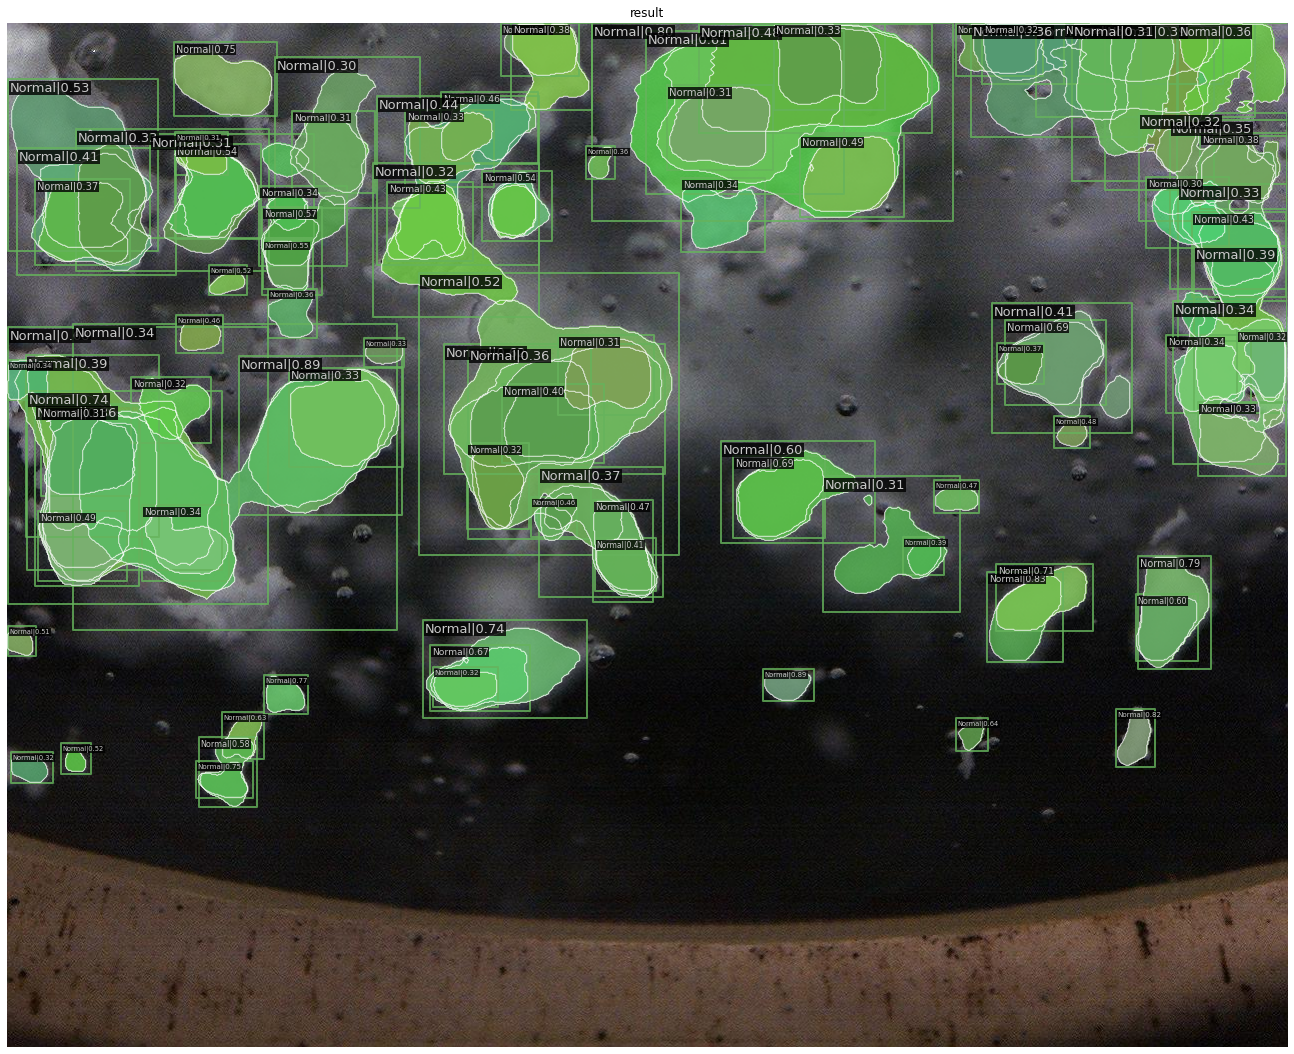

In [ ]:
img = mmcv.imread('/content/lg_test/mmdetection/data/dataset/test/0087.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

&nbsp;

### 모델 테스트 및 out json 확인

- 해당 코드는 mmdetection/tools/test.py 의 내용중에서 cfg를 바로 사용할수 있게 수정한 코드입니다.
- 추가적인 기능을 수행할때는 작동하지 않을수 있습니다. test.py 내용 확인은 해당 링크를 참조하시면 감사하겠습니다. 
[test.py](https://github.com/open-mmlab/mmdetection/blob/master/tools/test.py)


&nbsp;

- test를 수행하기 전에 cfg 기존 설정 다시 실행
- train을 수행하면서 설정된 내부 파라미터 초기화 위해서

In [ ]:
cfg = set_config()

In [ ]:
import argparse
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.utils import (build_ddp, build_dp, compat_cfg, get_device,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)





# 필요한 파라미터 설정
checkpoint='work_dirs/lg_mask/lg_cfg2/latest.pth' # 훈련시킨 모델 가중치
show=False
show_dir=None
show_score_thr=0.3
eval_options={'jsonfile_prefix': './work_dirs/out_json/predict'} # json 출력 저장위치
format_only = True
out = None





## 여기서 부터 기존의 mmdetection/tools/test.py 를 변경한 코드 ##

cfg = replace_cfg_vals(cfg)
update_data_root(cfg)
cfg = compat_cfg(cfg)
setup_multi_processes(cfg)



# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

if 'pretrained' in cfg.model:
    cfg.model.pretrained = None
elif 'init_cfg' in cfg.model.backbone:
    cfg.model.backbone.init_cfg = None

if cfg.model.get('neck'):
    if isinstance(cfg.model.neck, list):
        for neck_cfg in cfg.model.neck:
            if neck_cfg.get('rfp_backbone'):
                if neck_cfg.rfp_backbone.get('pretrained'):
                    neck_cfg.rfp_backbone.pretrained = None
    elif cfg.model.neck.get('rfp_backbone'):
        if cfg.model.neck.rfp_backbone.get('pretrained'):
            cfg.model.neck.rfp_backbone.pretrained = None



cfg.gpu_ids = [cfg.gpu_ids]
cfg.device = get_device()


distributed = False


test_dataloader_default_args = dict(
    samples_per_gpu=1, workers_per_gpu=2, dist=distributed, shuffle=False)

# in case the test dataset is concatenated
if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        # Replace 'ImageToTensor' to 'DefaultFormatBundle'
        cfg.data.test.pipeline = replace_ImageToTensor(
            cfg.data.test.pipeline)
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        for ds_cfg in cfg.data.test:
            ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

test_loader_cfg = {
    **test_dataloader_default_args,
    **cfg.data.get('test_dataloader', {})
}

rank, _ = get_dist_info()


# build the dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))

fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')


if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

if not distributed:
    # model = build_dp(model, torch.device(type = 'cuda'), device_ids=cfg.gpu_ids)
    model = build_dp(model, device_ids= range(1))
    outputs = single_gpu_test(model, data_loader, show, show_dir,
                              show_score_thr)


rank, _ = get_dist_info()
if rank == 0:
    if out:
        print(f'\nwriting results to {out}')
        mmcv.dump(outputs, out)
    kwargs = {} if eval_options is None else eval_options
    if format_only:
        dataset.format_results(outputs, **kwargs)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: work_dirs/lg_mask/lg_cfg2/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 350/350, 1.7 task/s, elapsed: 200s, ETA:     0s

&nbsp;

### !!!! 최종 결과물은 predict.segm.json 형식으로 제출 !!!!

In [ ]:
import json

with open("/content/lg_test/mmdetection/work_dirs/out_json/predict.bbox.json") as f:
    out_data1 = json.load(f)

with open("/content/lg_test/mmdetection/work_dirs/out_json/predict.segm.json") as f:
    out_data2 = json.load(f)

**segm.json 양식**



{'bbox': [564.3426513671875,

   673.5167236328125,

   87.98651123046875,

   64.25640869140625],

  'category_id': 1,

  'image_id': 0,

  'score': 0.9846856594085693,

  'segmentation': {'counts': 
  'ieea0>`o05L2N2O1N3N1O2M2O1O1N2O2M2O1N101N2N2N100O2N100N3N100O2O0O100O1O1000000O10O010000000O1000000O10001O001O0O101O1O2N0O2O1O1O1O1N3N001O1O1N3N2N1N2O1O1O2M4L2O1N2O1N3M4J8JdYgc0',

   'size': [1024, 1280]}},